C:\Users\aubai\AppData\Local\Temp\ipykernel_2788\2318126959.py:49: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Extrait de données :    transaction_id  compte_id  montant date_transaction type_transaction  \
0               9        121   4419.0       2024-01-21         Paiement   
1              26        417    296.0       2024-01-15          Retrait   
2              64         56   1191.0       2024-01-06         Paiement   
3             106        366   2142.0       2024-01-15            Dépôt   
4             150        314   1957.0       2024-01-05            Dépôt   

        lieu  fraude  client_id     nom   prénom  âge   sexe      pays  \
0  Bruxelles       0        192  Martin   Pierre   27  Femme    Canada   
1  Bruxelles       0         63  Dupont   Pierre   50  Homme    France   
2       Lyon       0        491  Dupont   Sophie   51  Homme  Belgique   
3  Bruxelles       1        212  Dupont   Sophie   64  Homme    Canada   
4       Lyon       0        547   Adams  Michael   44  Homme    Suisse   

   revenu_annuel  
0        64579.0  
1        36301.0  
2        50480.0  
3      

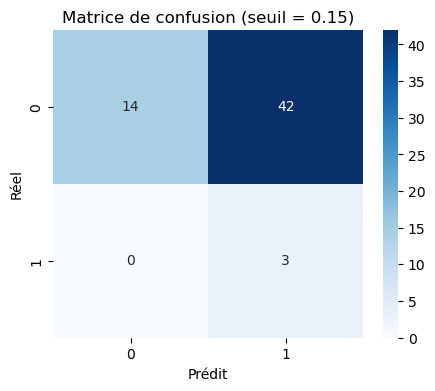

{'Probabilité de fraude': 0.29, 'Fraude détectée': True}


C:\Users\aubai\AppData\Local\Temp\ipykernel_2788\2318126959.py:150: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prediction = int(proba_fraude >= threshold)


In [1]:
import pandas as pd
import numpy as np
import mysql.connector

# scikit-learn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# imbalanced-learn
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns

# 🔹 Connexion à la base de données MySQL
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="Auba_reve196!",
    database="fraude_bancaire"
)

# 🔹 Requête pour extraire les transactions avec informations clients
query = """
SELECT
    t.transaction_id,
    t.compte_id,
    t.montant,
    t.date_transaction,
    t.type_transaction,
    t.lieu,
    t.fraude,
    c.client_id,
    c.nom,
    c.prénom,
    c.âge,
    c.sexe,
    c.pays,
    c.revenu_annuel
FROM Transactions t
JOIN Comptes co ON t.compte_id = co.compte_id
JOIN Clients c ON co.client_id = c.client_id
WHERE t.date_transaction BETWEEN '2024-01-01' AND '2024-12-31'
;
"""

df = pd.read_sql(query, conn)
conn.close()

print("Extrait de données :", df.head())

# 🔹 Transformation des données
df['date_transaction'] = pd.to_datetime(df['date_transaction'])
df['jour_semaine'] = df['date_transaction'].dt.weekday  # Jour de la semaine

# 🔹 Encodage des variables catégoriques
encoder_type = LabelEncoder()
df['type_transaction_enc'] = encoder_type.fit_transform(df['type_transaction'])

encoder_lieu = LabelEncoder()
df['lieu_enc'] = encoder_lieu.fit_transform(df['lieu'])

encoder_sexe = LabelEncoder()
df['sexe_enc'] = encoder_sexe.fit_transform(df['sexe'])

# 🔹 Feature Engineering
df['montant_relatif'] = df['montant'] / (df['revenu_annuel'] + 1e-6)  # Éviter la division par zéro
df['log_montant'] = np.log(df['montant'] + 1e-6)
df['log_revenu'] = np.log(df['revenu_annuel'] + 1e-6)

# 🔹 Sélection des features
features = [
    'montant', 'type_transaction_enc', 'lieu_enc', 'jour_semaine', 'âge', 
    'sexe_enc', 'revenu_annuel', 'montant_relatif', 'log_montant', 'log_revenu'
]
X = df[features]
y = df['fraude']

# 🔹 Séparation entraînement/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 🔹 Normalisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 🔹 Sur-échantillonnage SMOTE pour équilibrer les classes
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

print("Taille avant SMOTE :", X_train_scaled.shape, y_train.shape)
print("Taille après SMOTE :", X_train_res.shape, y_train_res.shape)

# 🔹 Entraînement du modèle
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_res, y_train_res)

# 🔹 Prédictions sur le test set
y_proba = model.predict_proba(X_test_scaled)[:, 1]

# 🔹 Ajuster le seuil : 0.15 (exemple)
threshold = 0.15
y_pred_threshold = (y_proba >= threshold).astype(int)

# 🔹 Évaluation
print("Seuil utilisé :", threshold)
print("Accuracy :", accuracy_score(y_test, y_pred_threshold))
print("Classification Report :\n", classification_report(y_test, y_pred_threshold))

# 🔹 Matrice de confusion
cm = confusion_matrix(y_test, y_pred_threshold)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"Matrice de confusion (seuil = {threshold})")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()

# 🔹 Fonction de détection de fraude
def detecter_fraude(transaction):
    # Convertir le dictionnaire en DataFrame
    transaction_df = pd.DataFrame([transaction])

    # Encodage avec gestion des nouvelles valeurs inconnues
    transaction_df['type_transaction_enc'] = encoder_type.transform([transaction['type_transaction']])[0] \
        if transaction['type_transaction'] in encoder_type.classes_ else -1
    transaction_df['lieu_enc'] = encoder_lieu.transform([transaction['lieu']])[0] \
        if transaction['lieu'] in encoder_lieu.classes_ else -1
    transaction_df['sexe_enc'] = encoder_sexe.transform([transaction['sexe']])[0] \
        if transaction['sexe'] in encoder_sexe.classes_ else -1

    # Ajout des nouvelles features
    transaction_df['montant_relatif'] = transaction_df['montant'] / (transaction_df['revenu_annuel'] + 1e-6)
    transaction_df['log_montant'] = np.log(transaction_df['montant'] + 1e-6)
    transaction_df['log_revenu'] = np.log(transaction_df['revenu_annuel'] + 1e-6)
    transaction_df['jour_semaine'] = pd.to_datetime(transaction_df.get('date_transaction', '2024-02-26')).dt.weekday

    # Sélectionner les mêmes features que pour l'entraînement
    X_new = transaction_df[features]

    # Normalisation
    X_new_scaled = scaler.transform(X_new)

    # Prédiction de la fraude
    proba_fraude = model.predict_proba(X_new_scaled)[:, 1]
    prediction = int(proba_fraude >= threshold)

    return {"Probabilité de fraude": proba_fraude[0], "Fraude détectée": bool(prediction)}

# 🔹 Exemple de transaction suspecte
transaction_test = {
    "montant": 8000000000.0,
    "type_transaction": "Retrait",
    "lieu": "New York",
    "date_transaction": "2024-02-26",
    "âge": 25,
    "sexe": "Homme",
    "revenu_annuel": 10000.0
}

# 🔹 Détection de fraude
print(detecter_fraude(transaction_test))


## Voici tout ce que fairt ce code 
    Charge et prétraite les données de la base MySQL
    Applique un encodage et un feature engineering avancé
    Équilibre les classes avec SMOTE
    Entraîne un modèle RandomForestClassifier
    Crée une fonction de détection de fraudes avec un seuil ajustable
    Corrige les erreurs liées aux valeurs inconnues et aux colonnes manquantes
    Test avec une transaction suspecte !

In [7]:
transactions = [
    {
        "montant": 8000000000.0,  # Retrait énorme
        "type_transaction": "Retrait",
        "lieu": "New York",
        "date_transaction": "2025-02-26",
        "âge": 25,
        "sexe": "Homme",
        "revenu_annuel": 10000.0
    },

    {
        "montant": 200.0,  # Petit retrait
        "type_transaction": "Retrait",
        "lieu": "Paris",
        "date_transaction": "2025-02-26",
        "âge": 45,
        "sexe": "Homme",
        "revenu_annuel": 45000.0
    },

    {
        "montant": 50.0,  # Achat normal
        "type_transaction": "Achat en ligne",
        "lieu": "Londres",
        "date_transaction": "2025-02-27",
        "âge": 30,
        "sexe": "Femme",
        "revenu_annuel": 40000.0
    },
    
    {
        "montant": 500000.0,  # Achat en ligne massif
        "type_transaction": "Achat en ligne",
        "lieu": "Dubaï",
        "date_transaction": "2025-03-01",
        "âge": 22,
        "sexe": "Femme",
        "revenu_annuel": 15000.0
    },

    {
        "montant": 1000.0,  # Paiement standard
        "type_transaction": "Paiement",
        "lieu": "Berlin",
        "date_transaction": "2025-03-10",
        "âge": 28,
        "sexe": "Homme",
        "revenu_annuel": 35000.0
    },
    
    {
        "montant": 20000000.0,  # Virement énorme vers l'étranger
        "type_transaction": "Virement",
        "lieu": "Hong Kong",
        "date_transaction": "2025-03-15",
        "âge": 30,
        "sexe": "Homme",
        "revenu_annuel": 20000.0
    },
    {
        "montant": 150000.0,  # Transaction très inhabituelle par rapport au revenu
        "type_transaction": "Paiement",
        "lieu": "Moscou",
        "date_transaction": "2025-04-01",
        "âge": 40,
        "sexe": "Femme",
        "revenu_annuel": 18000.0
    },

    {
        "montant": 2500.0,  # Facture classique
        "type_transaction": "Virement",
        "lieu": "Bruxelles",
        "date_transaction": "2025-04-15",
        "âge": 55,
        "sexe": "Femme",
        "revenu_annuel": 50000.0
    },
    
    {
        "montant": 50000000.0,  # Transfert massif d'argent
        "type_transaction": "Virement",
        "lieu": "Singapour",
        "date_transaction": "2025-05-10",
        "âge": 35,
        "sexe": "Homme",
        "revenu_annuel": 12000.0
    },

    {
        "montant": 120.0,  # Retrait normal
        "type_transaction": "Retrait",
        "lieu": "Madrid",
        "date_transaction": "2025-05-20",
        "âge": 38,
        "sexe": "Homme",
        "revenu_annuel": 42000.0
    }
]

for transaction in transactions :
    print(detecter_fraude(transaction))


{'Probabilité de fraude': 0.25, 'Fraude détectée': True}
{'Probabilité de fraude': 0.01, 'Fraude détectée': False}
{'Probabilité de fraude': 0.09, 'Fraude détectée': False}
{'Probabilité de fraude': 0.22, 'Fraude détectée': True}
{'Probabilité de fraude': 0.13, 'Fraude détectée': False}
{'Probabilité de fraude': 0.38, 'Fraude détectée': True}
{'Probabilité de fraude': 0.19, 'Fraude détectée': True}
{'Probabilité de fraude': 0.21, 'Fraude détectée': True}
{'Probabilité de fraude': 0.39, 'Fraude détectée': True}
{'Probabilité de fraude': 0.12, 'Fraude détectée': False}


C:\Users\aubai\AppData\Local\Temp\ipykernel_2788\2318126959.py:150: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prediction = int(proba_fraude >= threshold)
C:\Users\aubai\AppData\Local\Temp\ipykernel_2788\2318126959.py:150: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prediction = int(proba_fraude >= threshold)
C:\Users\aubai\AppData\Local\Temp\ipykernel_2788\2318126959.py:150: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prediction = int(proba_fraude >= thresh